### Topic Modelling with Gensim!

This notebook will walk you through the entire process of analysing your text - from pre-processing to creating your topic models and visualising them. 

python offers a very rich suite of NLP and CL tools, and we will illustrate these to the best of our capabilities.
Let's start by setting up our imports.

We will be needing: 
```
- Gensim
- matplotlib
- spaCy
- pyLDAVis
```


In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

C:\Users\asus\Anaconda2\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001. 

We should keep in mind we can use pretty much any textual data-set and go ahead with what we will be doing.

In [2]:
# since we're working in python 2.7, we need to make sure to clean our data to make it unicode consistent
def clean(text):
    return unicode(''.join([i if ord(i) < 128 else ' ' for i in text]))

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

### Pre-processing data!

It's been often said in Machine Learning and NLP algorithms - garbage in, garbage out. We can't have state-of-the-art results without data which is aa good. Let's spend this section working on cleaning and understanding our data set.
NTLK is usually a popular choice for pre-processing - but is a rather [outdated](https://explosion.ai/blog/dead-code-should-be-buried) and we will be checking out spaCy, an industry grade text-processing package. 

In [3]:
from spacy.en import English
nlp = spacy.load("en")

For safe measure, let's add some stopwords. It's a newspaper corpus, so it is likely we will be coming across variations of 'said' and 'Mister' which will not really add any value to the topic models.

In [6]:
my_stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [7]:
doc = nlp(clean(text))

Voila! With the `English` pipeline, all the heavy lifting has been done. Let's see what went on under the hood.

In [8]:
doc

Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year's Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at this

It seems like nothing, right? But spaCy's internal data structure has done all the work for us. Let's see how we can create our corpus. You can check out what a gensim corpus looks like [here](google.com).

In [9]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

And this is the magic of spaCy - just like that, we've managed to get rid of stopwords, punctauation markers, and added the lemmatized word. There's lot more we can do with spaCy which I would really recommend checking out.

Sometimes topic models make more sense when 'New' and 'York' are treated as 'New_York' - we can do this by creating a bigram model and modifying our corpus accordingly.

In [10]:
bigram = gensim.models.Phrases(texts)

In [11]:
texts = [bigram[line] for line in texts]

In [12]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

We're now done with a very important part of any text analysis - the data cleaning and setting up of corpus. It must be kept in mind that we created the corpus the way we did because that's how gensim requires it - most algorithms still require one to clean the data set the way we did, by removing stop words and numbers, adding the lemmatized form of the word, and using bigrams. 

### LSI

LSI stands for Latent Semantic Indeixing - it is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

In [11]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [12]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  u'-0.216*"israeli" + -0.211*"palestinian" + -0.196*"arafat" + -0.181*"force" + -0.149*"official" + -0.148*"kill" + -0.142*"people" + -0.142*"attack" + -0.129*"government" + -0.127*"australian"'),
 (1,
  u'-0.321*"palestinian" + -0.306*"israeli" + -0.299*"arafat" + 0.171*"australia" + 0.166*"australian" + -0.158*"israel" + 0.149*"afghanistan" + -0.137*"sharon" + -0.134*"hamas" + -0.124*"west_bank"'),
 (2,
  u'-0.266*"afghanistan" + -0.242*"force" + -0.191*"al_qaeda" + 0.180*"fire" + -0.176*"bin_laden" + -0.153*"pakistan" + 0.138*"good" + 0.138*"sydney" + -0.131*"tora_bora" + -0.129*"afghan"'),
 (3,
  u'0.373*"fire" + 0.270*"area" + 0.199*"sydney" + -0.191*"australia" + 0.176*"firefighter" + 0.160*"south" + 0.157*"north" + 0.148*"wind" + -0.146*"good" + 0.132*"wales"'),
 (4,
  u'-0.238*"company" + -0.221*"union" + 0.199*"test" + -0.187*"qantas" + -0.152*"australian" + 0.145*"good" + 0.141*"match" + 0.137*"win" + -0.136*"government" + -0.136*"worker"')]

### HDP

HDP, the Hierarchical Dirichlet process is an unsupervised topic model which figures out the number of topics on it's own.

In [13]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [14]:
hdpmodel.show_topics()

[(0,
  u'0.005*israeli + 0.003*arafat + 0.003*palestinian + 0.003*hit + 0.003*west_bank + 0.003*official + 0.002*sharon + 0.002*force + 0.002*afp + 0.002*arrest + 0.002*militant + 0.002*storm + 0.002*hamas + 0.002*strike + 0.002*come + 0.002*military + 0.002*source + 0.002*group + 0.002*soldier + 0.002*kill'),
 (1,
  u'0.004*company + 0.003*administrator + 0.002*yallourn + 0.002*entitlement + 0.002*traveland + 0.002*staff + 0.002*austar + 0.002*union + 0.002*travel + 0.002*employee + 0.002*end + 0.002*cent + 0.002*government + 0.002*remain + 0.002*go + 0.002*seek + 0.002*leave + 0.002*people + 0.002*agreement + 0.002*$'),
 (2,
  u'0.003*airport + 0.003*taliban + 0.002*kill + 0.002*opposition + 0.002*kandahar + 0.002*force + 0.002*night + 0.002*leave + 0.002*man + 0.002*lali + 0.002*near + 0.002*city + 0.001*wound + 0.001*end + 0.001*agha + 0.001*civilian + 0.001*gul + 0.001*people + 0.001*military + 0.001*injure'),
 (3,
  u'0.002*job + 0.002*australian + 0.002*cent + 0.002*read + 0.002

### LDA

LDA, or Latent Dirichlet Allocation is arguably the most famous topic modelling algorithm out there. Out here we create a simple topic model with 10 topics.

In [13]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [14]:
ldamodel.show_topics()

[(0,
  u'0.005*"test" + 0.005*"day" + 0.004*"australian" + 0.004*"government" + 0.004*"year" + 0.004*"force" + 0.004*"australia" + 0.003*"match" + 0.003*"area" + 0.003*"give"'),
 (1,
  u'0.007*"people" + 0.004*"australia" + 0.004*"government" + 0.004*"force" + 0.004*"australian" + 0.004*"new" + 0.004*"day" + 0.003*"power" + 0.003*"party" + 0.003*"take"'),
 (2,
  u'0.005*"people" + 0.005*"australia" + 0.004*"government" + 0.004*"australian" + 0.004*"day" + 0.003*"test" + 0.003*"go" + 0.003*"police" + 0.003*"force" + 0.003*"today"'),
 (3,
  u'0.006*"australian" + 0.006*"year" + 0.005*"people" + 0.004*"australia" + 0.004*"attack" + 0.004*"force" + 0.004*"israeli" + 0.004*"palestinian" + 0.004*"government" + 0.004*"official"'),
 (4,
  u'0.007*"australia" + 0.005*"people" + 0.005*"man" + 0.005*"government" + 0.004*"force" + 0.004*"new" + 0.004*"day" + 0.004*"palestinian" + 0.004*"claim" + 0.003*"report"'),
 (5,
  u'0.006*"australia" + 0.005*"police" + 0.004*"year" + 0.004*"come" + 0.003*"at

### pyLDAvis 

Thanks to pyLDAvis, we can visualise our topic models in a really handy way. All we need to do is enable our notebook and prepare the object.

In [15]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      26.470011        1       1  0.028757  0.016082
6      11.789357        1       2  0.023576  0.034961
4      11.404139        1       3  0.016066  0.029964
1      11.363277        1       4 -0.031134  0.034362
0      10.478491        1       5 -0.057773 -0.013058
5       6.701160        1       6  0.009097 -0.000097
9       6.537562        1       7  0.024536 -0.002136
2       5.658028        1       8 -0.023966 -0.024875
8       5.464129        1       9 -0.024762 -0.011297
7       4.133845        1      10  0.035604 -0.063905, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
1715  Default   43.000000              test   43.000000  30.0000  30.0000
300   Default  113.000000            people  113.000000  29.0000  29.0000
5291  Default   59.000000            arafat   59.000000  28.0000  28.0000
1461  Default   80.000000       palestinian   80.000000  27.0000  27.0000
757   Default   58.000000           company   58.000000  26.0000  26.0000
244   Default   40.000000             child   40.000000  25.0000  25.0000
966   Default  122.000000         australia  122.000000  24.0000  24.0000
885   Default   64.000000              kill   64.000000  23.0000  23.0000
3240  Default   70.000000            police   70.000000  22.0000  22.0000
5392  Default   37.000000            centre   37.000000  21.0000  21.0000
999   Default   12.000000  governor_general   12.000000  20.0000  20.0000
4452  Default   20.000000          detainee   20.000000  19.0000  19.0000
3960  Default   99.000000               day   99.000000  18.0000  18.0000
1480  Default   28.000000             india   28.000000  17.0000  17.0000
2800  Default   53.000000              call   53.000000  16.0000  16.0000
4597  Default  125.000000        australian  125.000000  15.0000  15.0000
1941  Default   82.000000           israeli   82.000000  14.0000  14.0000
2654  Default   27.000000             party   27.000000  13.0000  13.0000
5563  Default   12.000000             space   12.000000  12.0000  12.0000
2307  Default   28.000000             match   28.000000  11.0000  11.0000
3206  Default   47.000000             claim   47.000000  10.0000  10.0000
851   Default   32.000000              play   32.000000   9.0000   9.0000
142   Default    7.000000            hewitt    7.000000   8.0000   8.0000
5261  Default   27.000000             metre   27.000000   7.0000   7.0000
2443  Default   38.000000               win   38.000000   6.0000   6.0000
1863  Default  107.000000              year  107.000000   5.0000   5.0000
3947  Default   19.000000             labor   19.000000   4.0000   4.0000
234   Default   54.000000             union   54.000000   3.0000   3.0000
2410  Default   48.000000                go   48.000000   2.0000   2.0000
3993  Default   52.000000             south   52.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
1123  Topic10    2.866726              high   23.434797   1.0849  -6.0270
2140  Topic10    1.415135         coalition    6.826057   1.6124  -6.7329
4209  Topic10    2.148067              risk   15.254606   1.2256  -6.3156
315   Topic10    1.837675          facility   11.739501   1.3315  -6.4717
5184  Topic10    2.104963              lose   15.689105   1.1773  -6.3359
4597  Topic10    5.699833        australian  125.757498   0.0920  -5.3397
885   Topic10    3.983783              kill   64.178254   0.4065  -5.6979
3993  Topic10    3.496782             south   52.193147   0.4829  -5.8283
4759  Topic10    2.249589        helicopter   20.115221   0.9952  -6.2694
1022  Topic10    2.401484              line   23.630456   0.8995  -6.2041
244   Topic10    2.894390             child   40.365578   0.5508  -6.0174
3276  Topic10    3.112605             think   50.3283




### Topic Coherence

Topic Coherence is a new gensim functionality where we can identify which topic model is 'better'. 
By returning a score, we can compare between different topic models of the same. We use the same example from the news classification notebook to plot a graph between the topic models we have created.

In [18]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [19]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [20]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

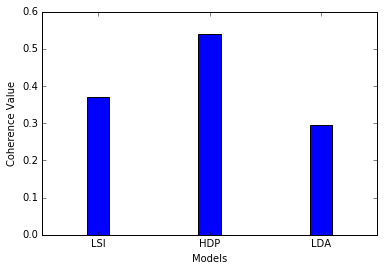

In [21]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

We can see that topic coherence helped us get past manually inspecting our topic models - we can now keep fine tuning our models and compare between them to see which has the best performance. 

